# EEG to Image Generation
Robert Sato, Alexander Cardaras
<br>UC Santa Cruz
## Version Info
### Updated: 4/11/21

## Issues:
- images saved as flat 1D array (64x64x3)
    - try using this flat image as input to the network and simply reshape at the input for CNN
    - not sure if it is faster to reshape before giving the image as input to the CNN or to reshape in the CNN after reading the input

## General Notes
- change the loaded images to save the pixel values as uint8
-  change the LSTM model to the one in the paper
- still use 2D convolution layers for rgb images (64x64x3) is a 2D image with 3 channels not a 3D image

## Revisions
- added loading of images
- GAN blog implementation works
- started modified version for ImageNet data
- reshaping inside the CNN seems to work fine. input_shape = 12288, reshape input layer -> (None, 64, 64, 3)
- load_image_net_data(scale=False) loads the image net data and changes the dimensions to 2D RGB image
    - True scales the values to [-1, 1]

# Directions:
- **Execute** mount drive cell
- **Skip** load, convert and save data to Numpy files section
- **Execute** cells starting from **Classify the EEG wave data section**

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

**Mount drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load, convert and save data to Numpy files
- only executed once to generate .npy files
- load the .npy files directly for future use

In [ ]:
import torch
import numpy as np
from numpy import save
from numpy import load

In [ ]:
# use the default data_path
# eeg_55_95_std.pth - saved
# eeg_14_70_std.pth - saved
# eeg_5_95_std.pth - saved

raw_data_path = "/content/gdrive/MyDrive/EEG2Image/eeg_55_95_std.pth"
save_data_path = "/content/gdrive/MyDrive/EEG2Image/data/"

In [ ]:
# load eeg data from .pth files
loaded = torch.load(raw_data_path)
data = loaded['dataset']        
labels = loaded["labels"]
images = loaded["images"]
size = len(data)
print(size)

11965


In [ ]:
# convert data tensors to np
eeg_data = []
labels = []

# crop the first 20ms and last 40ms out
time_low = 20
time_high = 460

verbose = False # set to True to print information on the data

for i in range(size):
    if verbose:
        data_i = data[i]
        print("Keys stored in each data[i] object:", data_i.keys())

        eeg_i = data[i]["eeg"]
        print("Shape of data[i][\"eeg\"]:", eeg_i.shape)
        print("Type of data[i][\"eeg\"]:", eeg_i.type)
        print()

        eeg_f = data[i]["eeg"].float() # simply converts to float
        print("Shape of data[i][\"eeg\"].float():", eeg_f.shape)
        print("Type of data[i][\"eeg\"].float():", eeg_f.type)
        print()

        eeg_t = data[i]["eeg"].float().t() # transposes the matrix
        print("Shape of data[i][\"eeg\"].float().t():", eeg_t.shape)
        print("Type of data[i][\"eeg\"].float().t():", eeg_t.type)
        print()

        image = data[i]["image"]
        print("image:", image)

        label = data[i]["label"]
        print("label:", label)

        subject = data[i]["subject"]
        print("subject:", subject)

    eeg = data[i]["eeg"].float().t()
    eeg = eeg[time_low:time_high,:] # trim the data to between 0.2s - 0.46s
    label = data[i]["label"]

    # convert from tensor to numpy
    eeg_data.append(eeg.numpy())
    labels.append(label)

eeg_data = np.asarray(eeg_data)
labels = np.asarray(labels)
print("Shape of EEG data:", eeg_data.shape)
print("Shape of labels:", labels.shape)

Shape of EEG data: (11965, 440, 128)
Shape of labels: (11965,)


### Information about the .pth file data
- 6 subjects
- 40 image classes
- 50 images per class

6 subjects * 40 classes * 50 images/class = 12,000 segments
- each image (segment) = .5 ms @ 1kHz = 500 samples during the segment
- each sample = 128 channels

each segment = 128 * 500 voltage values

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy", eeg_data)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy", labels)

In [ ]:
eeg_data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy")

In [ ]:
print(eeg_data.shape)

(11965, 440, 128)


# Classify the EEG wave data
- load the data
- build a model
- train the model
- evaluate
- predict

**Load the Data**

In [2]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# options for data separated by frequency bands
# eeg_55_95.npy
# eeg_14_70.npy
# eeg_5_95.npy

data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_5_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_5_95.npy")

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (11965, 440, 128)
Labels shape: (11965,)


**LSTM stuff**

In [ ]:
# initialize training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 42)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

# one hot encode the labels
y_train = to_categorical(y_train, 40)
y_test = to_categorical(y_test, 40)

Shape of x_train: (9572, 440, 128)
Shape of y_train: (9572,)
Shape of x_test: (2393, 440, 128)
Shape of y_test: (2393,)


In [ ]:
# define parameters
BATCH_SIZE = 16
EPOCHS = 50

TIMESTEPS = len(data[0])
TOTAL_INPUTS = len(data)
DATA_POINTS = TOTAL_INPUTS * TIMESTEPS 
FEATURES = len(x_train[0][0])

print('TIMESTEPS =', TIMESTEPS)
print('TOTAL_INPUTS =', TOTAL_INPUTS)
print('DATA_POINTS =', DATA_POINTS)
print('FEATURES =', FEATURES)

TIMESTEPS = 440
TOTAL_INPUTS = 11965
DATA_POINTS = 5264600
FEATURES = 128


In [ ]:
# LSTM model
model = Sequential()
#model.add(LSTM(128, batch_input_shape = (BATCH_SIZE, TIMESTEPS, FEATURES))) 
model.add(LSTM(16, input_shape = (TIMESTEPS, FEATURES)))
model.add(Dense(40, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                680       
Total params: 9,960
Trainable params: 9,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=2)

Epoch 1/50
599/599 - 9s - loss: 3.6998 - accuracy: 0.0259
Epoch 2/50
599/599 - 7s - loss: 3.6402 - accuracy: 0.0472
Epoch 3/50
599/599 - 7s - loss: 3.5244 - accuracy: 0.0625
Epoch 4/50
599/599 - 7s - loss: 3.4035 - accuracy: 0.0750
Epoch 5/50
599/599 - 7s - loss: 3.3578 - accuracy: 0.0771
Epoch 6/50
599/599 - 7s - loss: 3.2310 - accuracy: 0.0930
Epoch 7/50
599/599 - 7s - loss: 3.1756 - accuracy: 0.1008
Epoch 8/50
599/599 - 7s - loss: 3.1064 - accuracy: 0.1069
Epoch 9/50
599/599 - 7s - loss: 3.0531 - accuracy: 0.1098
Epoch 10/50
599/599 - 7s - loss: 3.0404 - accuracy: 0.1159
Epoch 11/50
599/599 - 7s - loss: 2.9898 - accuracy: 0.1204
Epoch 12/50
599/599 - 7s - loss: 2.9238 - accuracy: 0.1265
Epoch 13/50
599/599 - 7s - loss: 2.8564 - accuracy: 0.1268
Epoch 14/50
599/599 - 7s - loss: 2.8708 - accuracy: 0.1290
Epoch 15/50
599/599 - 7s - loss: 2.8560 - accuracy: 0.1325
Epoch 16/50
599/599 - 7s - loss: 2.8225 - accuracy: 0.1366
Epoch 17/50
599/599 - 7s - loss: 2.7218 - accuracy: 0.1499
Epoch 

In [ ]:
train_loss,train_acc = model.evaluate(x_train,y_train)
test_loss, test_acc = model.evaluate(x_test,y_test)
print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

75/75 [==============================] - 1s 10ms/step - loss: 2.6777 - accuracy: 0.1617
Training set accuracy: 0.2054951936006546
Test set accuracy: 0.16172169148921967


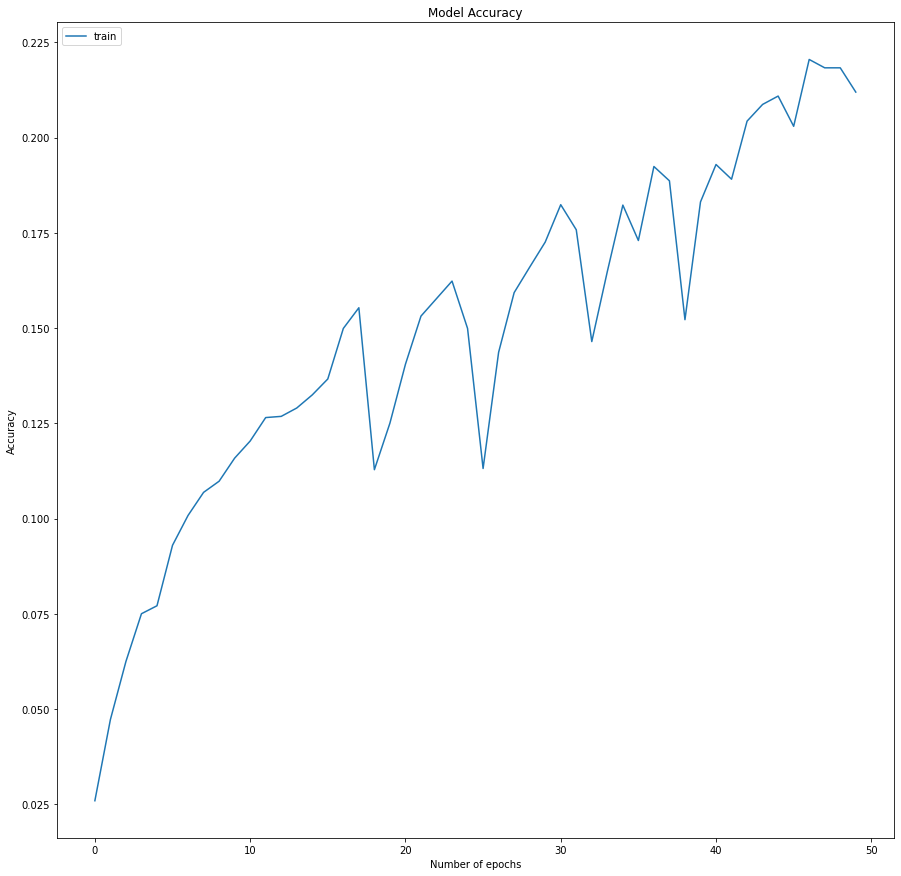

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
num_predictions = 100
correct_pred = 0
pred = np.argmax(model.predict(x_test[0:num_predictions]), axis=-1)
print_count = 0

print("Predicted class : Class label")
for i in range(num_predictions):
    label = np.argmax(y_test[i])
    #print(pred[i], "=?", label)
    print("{:2s} : {:2s}".format(str(pred[i]), str(label)), end= "     ")
    
    print_count += 1
    if print_count == 5:
        print()
        print_count = 0

    if pred[i] == label:
        correct_pred += 1

print("\nTotal correct predictions:", correct_pred)
print("Percent correct:", correct_pred/num_predictions)

Predicted class : Class label
39 : 39     38 : 17     15 : 24     4  : 14     9  : 23     
0  : 37     17 : 10     17 : 4      19 : 7      26 : 6      
20 : 23     26 : 23     22 : 26     13 : 29     10 : 15     
31 : 25     13 : 25     20 : 14     34 : 4      3  : 3      
11 : 0      33 : 2      14 : 16     7  : 32     39 : 11     
8  : 35     19 : 1      16 : 26     16 : 30     31 : 26     
17 : 25     1  : 29     13 : 32     27 : 20     12 : 8      
10 : 34     17 : 17     31 : 16     3  : 36     33 : 9      
36 : 18     11 : 0      37 : 25     6  : 6      35 : 11     
37 : 4      12 : 39     35 : 3      36 : 3      8  : 28     
13 : 7      19 : 19     39 : 21     19 : 29     12 : 5      
3  : 3      20 : 1      2  : 23     35 : 28     14 : 14     
16 : 30     12 : 0      27 : 4      15 : 10     27 : 1      
24 : 4      33 : 29     27 : 6      0  : 11     10 : 17     
34 : 4      4  : 4      14 : 14     37 : 17     37 : 25     
37 : 34     39 : 14     25 : 16     27 : 26     25 : 5 

# Loading Image Net dataset

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import collections

In [6]:
def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

In [4]:
# only exec once to copy image_mapping.npy over to local
!ls /content/gdrive/MyDrive/EEG2Image/data/
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content/

eeg_14_70.npy  eeg_5_95.npy	  labels_14_70.npy  labels_5_95.npy
eeg_55_95.npy  image_mapping.npy  labels_55_95.npy


In [59]:
def convert_data(data, image_shape=(64,64,3), scale=True):
    print("Converting data shape to 2D with 3 channels")
    if len(image_shape) != 3:
        print("Unexpected image_shape in convert_data")
        return -1
    # change the dimensions and scale
    # create new list to store the data in the correct format
    formatted_data = []
    count = 0
    for image in data:
        count += 1
        # convert from flat to 2D
        # formatted_data.append(array_to_image(image)) # that function changes bounds
        reshaped = image.reshape(3, 64, 64).transpose(1, 2, 0)
        formatted_data.append(reshaped)
    X = np.asarray(formatted_data)
    if scale:
        print("scaling values to the range [-1, 1]")
        X = X.astype('float32') # caution: storing lots of intermediate representation of image set
        X = (X - 127.5) / 127.5
    print("formatted shape:", X.shape)
    return X

In [60]:
# emulate the load_data() function but only return (images, labels)
# scale flag scales the input to [-1, 1] if true
def load_image_net_data(scale=True):
    mapping = load_mapping("image_mapping.npy", as_dict=False)
    # images stored as flat
    images = []
    num_images_per_class = 900
    for elem in mapping:
        images.append(np.asarray(elem[0:num_images_per_class])) # not all the same size so trim to 900 images per class
    images = np.asarray(images)
    num_classes = images.shape[0]
    print("shape of the data:", images.shape) # (40, 900, 12288) but want (900, 64, 64, 3)
    print("classes:", images.shape[0])
    print("images per class:", images.shape[1])
    print("pixel values in images:", images.shape[2])
    
    # append all classes into one list
    mapping = []
    for image_class in range(num_classes):
        for image in range(num_images_per_class):
            # append this image to one long new list
            mapping.append(images[image_class][image])
    mapping = np.asarray(mapping)
    print("shape after removing classes:", mapping.shape)

    data = convert_data(mapping, (64,64,3), scale)

    # create the labels
    labels = np.arange(0, 40, 1) # create labels 0 -> 39
    labels = np.repeat(labels, num_images_per_class) # repeat each label for num images per class
    return data, labels

In [84]:
data, labels = load_image_net_data(scale=True)
print(data.shape)
print(labels.shape)
#print(data[0])
print("min:", np.amin(data[0]))
print("max:", np.amax(data[1]))

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)
(36000, 64, 64, 3)
(36000,)
min: -0.9607843
max: 1.0


shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
formatted shape: (36000, 64, 64, 3)
Showing the first 10 images classes


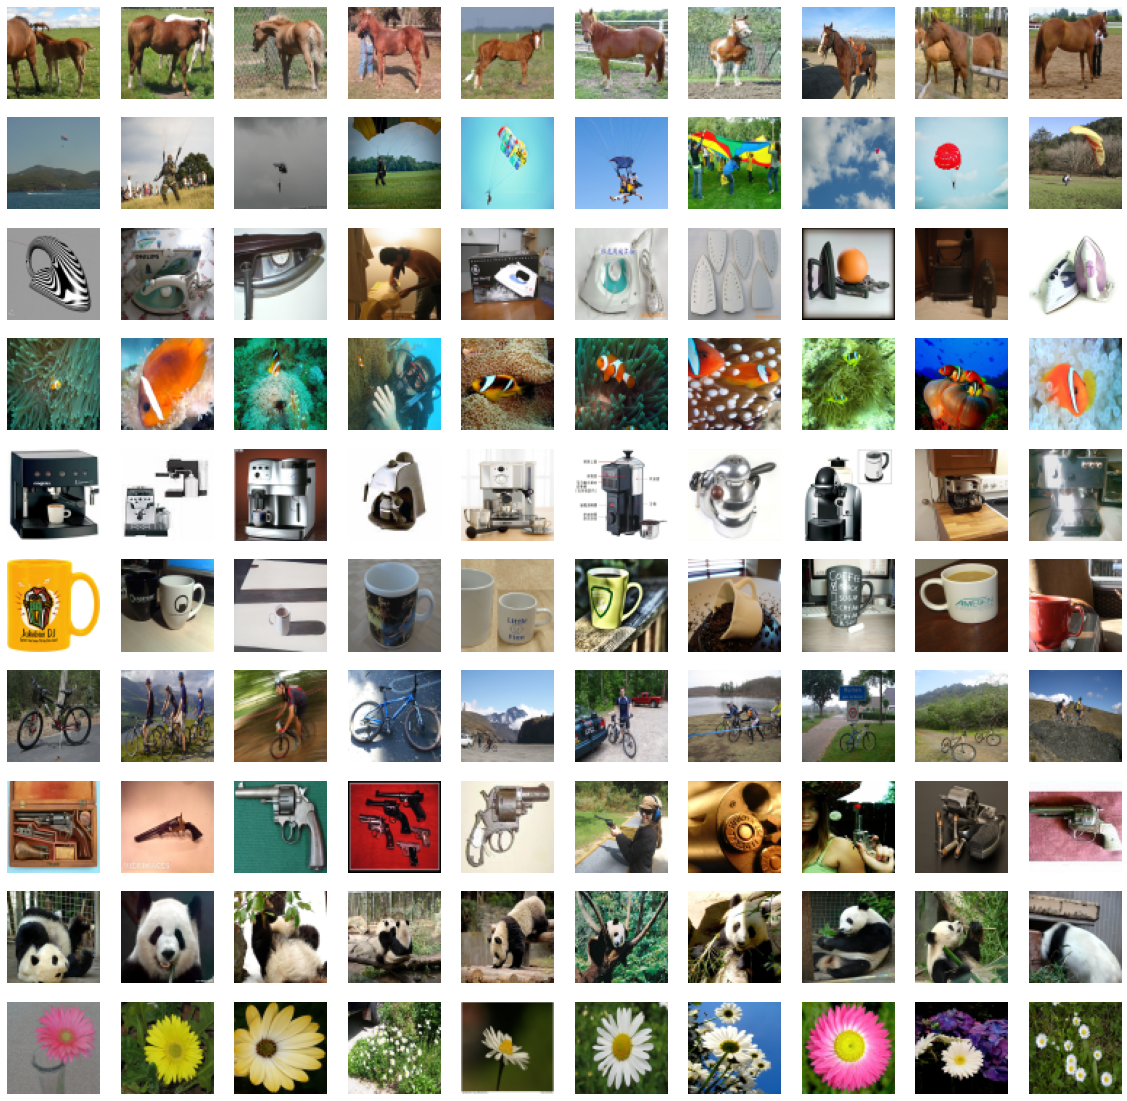

In [57]:
trainX, trainY = load_image_net_data(scale=False)
images_per_class = 900
print("Showing the first 10 images classes")
plt.figure(figsize=(20, 20))
# plot images from the training dataset
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	# every 10, skip rest of images in the class
	#plt.imshow(array_to_image( trainX[i + ((i//10)*images_per_class)] ))
	plt.imshow( trainX[i + ((i//10)*images_per_class)] )
plt.show()

155


**done loading images**

# Conditional Generative Adversarial Network

**Discriminator**

In [105]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

**Reference:**
details of these models are taken from: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [71]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # normal 
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample; added an extra layer of downsampling to get the compressed image to 8x8
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

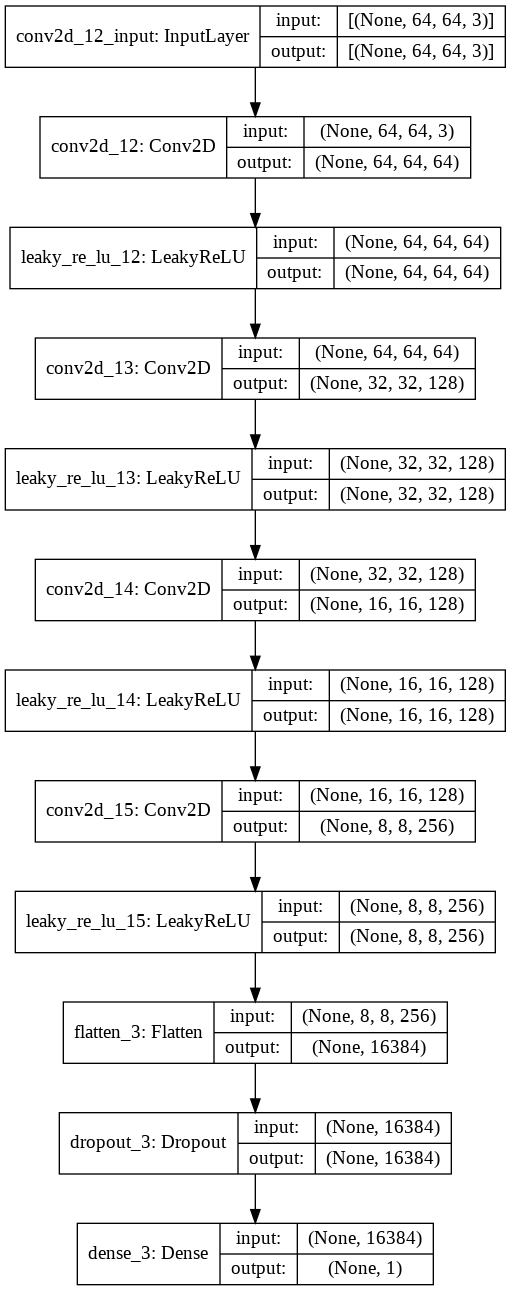

In [73]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [93]:
# generate fake images w random pixel values in range [0,1] then scale to [-1,1]
# this does not have a generator and was only used for testing the discriminator
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(64 * 64 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 64, 64, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [85]:
X, y = generate_fake_samples(10)
print(np.amin(X))
print(np.amax(X))

-0.9999714967286162
0.9999865738700813


In [86]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [87]:
dataset, labels = load_image_net_data(scale=True)
# test discriminator
model = define_discriminator()
model.summary()

print("Training discriminator")
train_discriminator(model, dataset)

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       14

**Generator**

In [104]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [90]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 8x8 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)      

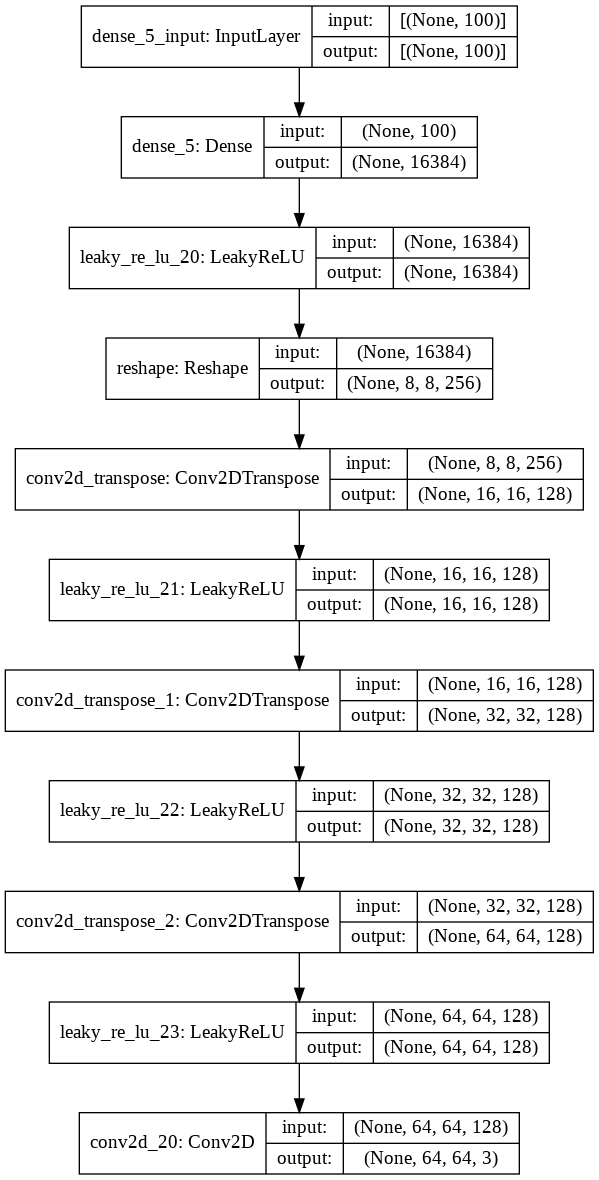

In [91]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [94]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [95]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

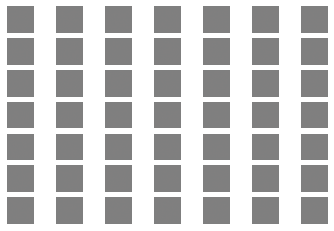

In [98]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i])
# show the figure
plt.show()
# random grey images bc not trained

**Training the Generator Model**

In [99]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 64, 64, 3)         2707203   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 534785    
Total params: 3,241,988
Trainable params: 2,707,203
Non-trainable params: 534,785
_________________________________________________________________


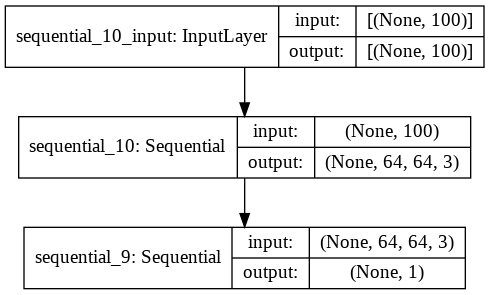

In [100]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [107]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [109]:
# execute training
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset, _ = load_image_net_data()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs= 20)

Streaming output truncated to the last 5000 lines.
>3, 61/281, d1=0.518, d2=0.591 g=1.168
>3, 62/281, d1=0.556, d2=0.580 g=1.219
>3, 63/281, d1=0.457, d2=0.504 g=1.220
>3, 64/281, d1=0.580, d2=0.525 g=1.164
>3, 65/281, d1=0.481, d2=0.671 g=1.111
>3, 66/281, d1=0.547, d2=0.730 g=1.257
>3, 67/281, d1=0.757, d2=0.766 g=1.324
>3, 68/281, d1=0.595, d2=0.534 g=1.375
>3, 69/281, d1=0.614, d2=0.541 g=1.444
>3, 70/281, d1=0.584, d2=0.430 g=1.536
>3, 71/281, d1=0.531, d2=0.428 g=1.580
>3, 72/281, d1=0.446, d2=0.405 g=1.888
>3, 73/281, d1=0.473, d2=0.450 g=1.768
>3, 74/281, d1=0.418, d2=0.484 g=1.655
>3, 75/281, d1=0.389, d2=0.474 g=1.611
>3, 76/281, d1=0.471, d2=0.540 g=1.442
>3, 77/281, d1=0.478, d2=0.648 g=1.389
>3, 78/281, d1=0.428, d2=0.543 g=1.428
>3, 79/281, d1=0.570, d2=0.636 g=1.367
>3, 80/281, d1=0.496, d2=0.563 g=1.436
>3, 81/281, d1=0.539, d2=0.552 g=1.361
>3, 82/281, d1=0.578, d2=0.622 g=1.477
>3, 83/281, d1=0.605, d2=0.631 g=1.428
>3, 84/281, d1=0.533, d2=0.531 g=1.347
>3, 85/281, d

In [112]:
gan_model.save("gan_model_020.h5")
d_model.save("discriminator_model_020.h5")

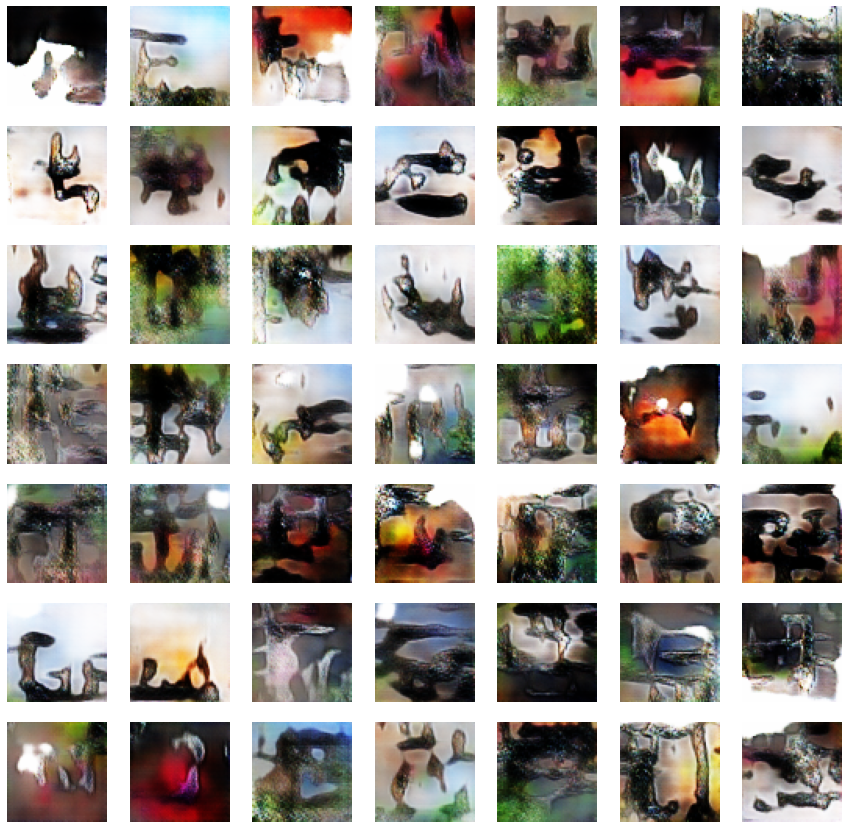

In [117]:
from keras.models import load_model
# load the saved model and generate images
!cp /content/gdrive/MyDrive/EEG2Image/models/generator_model_020.h5 /content/
g_model = load_model('generator_model_020.h5')

# size of the latent space
latent_dim = 100
# generate samples
n_samples = 49
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
plt.figure(figsize=(15, 15))
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i])
# show the figure
plt.show()
# random grey images bc not trained

In [113]:
# copy the models -> models folder
!cp /content/*.h5 /content/gdrive/MyDrive/EEG2Image/models/

# Trying example GAN from blogpost
Reference: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

### Plan:
- reread blogpost
- get base code working (generate images from example dataset)
- generate images from our dataset (ImageNet)
    - only do 1 (not all 40) class of images
- generate images for all 40 classes
- generate images given the class

In [29]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [11]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


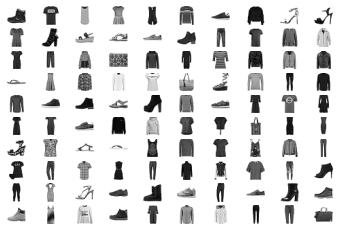

In [23]:
# plot raw pixel data
#plt.imshow(trainX[1], cmap='gray')
#print(type(trainX[1][0][0]))
# values stored as uint8; our ImageNet classes should be saved the same way
# plot images from the training dataset
for i in range(100):
	# define subplot
	plt.subplot(10, 10, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [25]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)): # see if you can simply call it with (64x64x3)
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [51]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7 # 128 copies of low resolution versions of the output image
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    # note: not compiled because this model is not trained directly
	return model

In [26]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [43]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	#print(trainX[0].shape) # initially just (28, 28)
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	#print(X[0].shape) # (28, 28, 1)
	#print(type(X[0][0][0][0])) # <class 'numpy.uint8'>
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [44]:
samples = load_real_samples()
print(samples.shape)

(60000, 28, 28, 1)


In [45]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [46]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [47]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [53]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [54]:
# call all helper functions and execute training
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>10, 149/468, d1=0.690, d2=0.692 g=0.728
>10, 150/468, d1=0.722, d2=0.685 g=0.726
>10, 151/468, d1=0.715, d2=0.700 g=0.720
>10, 152/468, d1=0.712, d2=0.689 g=0.718
>10, 153/468, d1=0.697, d2=0.686 g=0.731
>10, 154/468, d1=0.701, d2=0.681 g=0.733
>10, 155/468, d1=0.705, d2=0.667 g=0.731
>10, 156/468, d1=0.688, d2=0.685 g=0.728
>10, 157/468, d1=0.686, d2=0.703 g=0.718
>10, 158/468, d1=0.685, d2=0.704 g=0.712
>10, 159/468, d1=0.695, d2=0.697 g=0.719
>10, 160/468, d1=0.710, d2=0.700 g=0.711
>10, 161/468, d1=0.693, d2=0.700 g=0.725
>10, 162/468, d1=0.703, d2=0.695 g=0.731
>10, 163/468, d1=0.701, d2=0.687 g=0.719
>10, 164/468, d1=0.694, d2=0.667 g=0.729
>10, 165/468, d1=0.690, d2=0.692 g=0.728
>10, 166/468, d1=0.702, d2=0.695 g=0.716
>10, 167/468, d1=0.696, d2=0.702 g=0.717
>10, 168/468, d1=0.691, d2=0.711 g=0.712
>10, 169/468, d1=0.698, d2=0.686 g=0.728
>10, 170/468, d1=0.697, d2=0.681 g=0.719
>10, 171/468, d1=0.705, d2=0.700 g=0.703
>10, 1

In [68]:
# save the model to models folder
!ls /content/gdrive/MyDrive/EEG2Image/models/
!ls /content/

generator.h5  lstm_21_test_acc
gdrive	image_mapping.npy  sample_data


In [58]:
# copy the model -> models folder
!cp /content/generator.h5 /content/gdrive/MyDrive/EEG2Image/models/

In [69]:
# copy the model from models folder to local
!cp /content/gdrive/MyDrive/EEG2Image/models/generator.h5 /content/

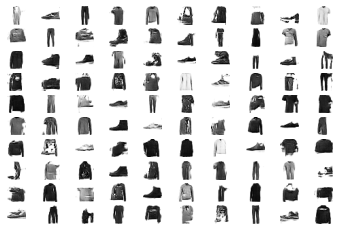

In [70]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)